# Titanic Machine Learning Project

### Add Imports

In [72]:
#Imports

#data imports
import pandas as pd
import numpy as np

#machine learning imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns


### Create the Dataframe

In [73]:
data = pd.read_csv("data/titanic.csv")
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Fill in missing ages

In [74]:
def fill_missing_ages(df):
    age_fill_map = {}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass] = df[df["Pclass"] == pclass]["Age"].median()

    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)


### Data Cleaning and Feature Engineering

In [75]:
def preprocess_data(df):
    # Delete all Columns/data aren't relevant for what we're trying to accomplish
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"], inplace=True)

    #Fill in missing data from Embarked
    # df["Embarked"].fillna("S", inplace=True)
    # df.drop(columns=["Embarked"], inplace=True)
    
    fill_missing_ages(df)

    # Convert Gender to binary for machine learning
    df["Sex"] = df["Sex"].map({"male":1, "female":0})

    # Feature Engineering: Creating new columns in our data to help enhance the model
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0)
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0,12,20,40,60, np.inf], labels=False)

    return df




### Update and check the Data

In [76]:
data = preprocess_data(data)

#display(data.head(10))
display(data.sample(10))
#display(data.tail(10))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FareBin,AgeBin
271,1,3,1,25.0,0,0,0.000,0,1,0,2
626,0,2,1,57.0,0,0,12.350,0,1,1,3
580,1,2,0,25.0,1,1,30.000,2,0,2,2
695,0,2,1,52.0,0,0,13.500,0,1,1,3
522,0,3,1,24.0,0,0,7.225,0,1,0,2
612,1,3,0,24.0,1,0,15.500,1,0,2,2
80,0,3,1,22.0,0,0,9.000,0,1,1,2
440,1,2,0,45.0,1,1,26.250,2,0,2,3
10,1,3,0,4.0,1,1,16.700,2,0,2,0
95,0,3,1,24.0,0,0,8.050,0,1,1,2


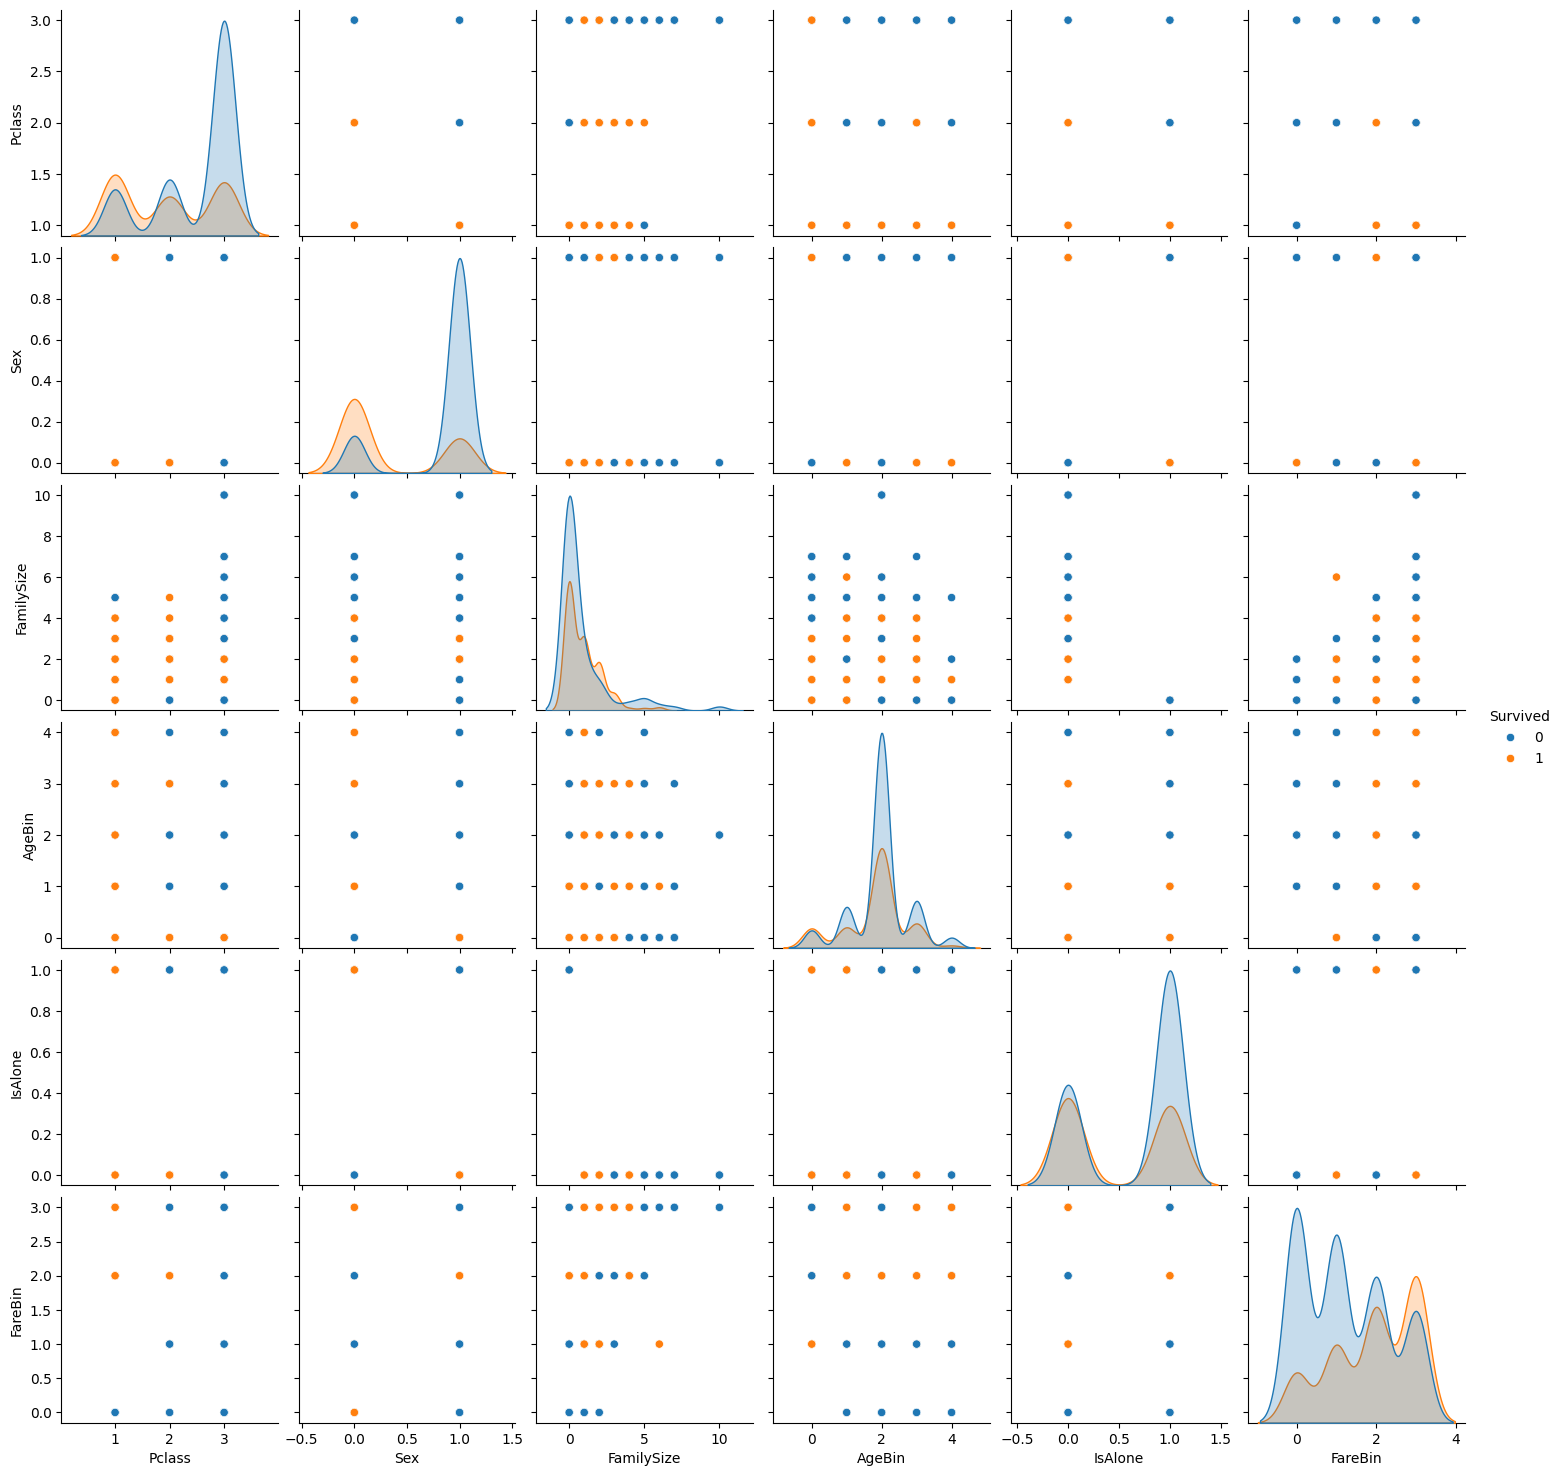

In [84]:
numeric_cols = ["Survived", "Pclass", "Sex", "FamilySize", "AgeBin", "IsAlone", "FareBin"]
sns.pairplot(data[numeric_cols], hue="Survived")

### Create Features / Target Variables (Make Flashcards)

In [78]:
X = data.drop(columns=["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### ML Preprocessing
When we take our data and we make sure it's numerically formatted for the model to understand

In [79]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Hyperparameter Tuning - KNN

In [80]:
def tune_model(X_train, y_train):
    param_grid = {
        "n_neighbors":range(1,21),
        "metric" : ["euclidean", "manhetten", "minkowski"],
        "weights" : ["uniform", "distance"]
    }

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

best_model = tune_model(X_train, y_train)

c:\Users\dslem\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
200 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dslem\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dslem\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\U

### Predictions and Evaluate

In [81]:
def evaluate_model(model, X_test, y_test):
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    matrix = confusion_matrix(y_test, prediction)
    return accuracy, matrix

accuracy, matrix = evaluate_model(best_model, X_test, y_test)

In [82]:
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Confusion Matrix:')
print(matrix)

Accuracy: 80.27%
Confusion Matrix:
[[115  19]
 [ 25  64]]


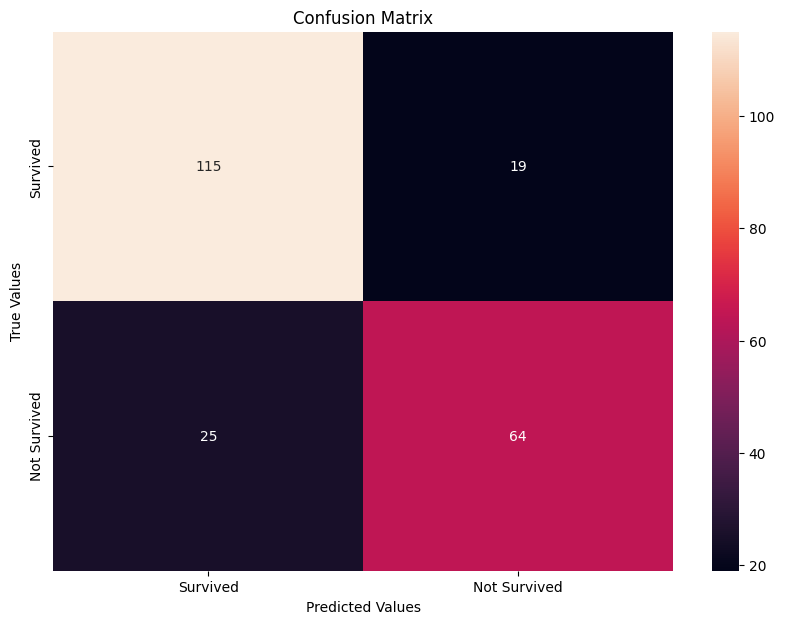

In [83]:
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Survived", "Not Survived"], yticklabels=["Survived", "Not Survived"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.show()

plot_model(matrix)